In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime, timedelta

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Set style for plots
plt.style.use('fivethirtyeight')
sns.set_palette("Set2")

In [5]:
df = pd.read_excel('Online Retail.xlsx')

print("Data Shape:", df.shape)
print("\nFirst 5 rows of data:")
print(df.head())
print("\nData info:")
print(df.info())

# missing values
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percent})
missing_df = missing_df[missing_df['Missing Values'] > 0].sort_values('Percentage', ascending=False)

print("\nColumns with missing values:")
print(missing_df)

# date range
print(f"\nDate range: {df['InvoiceDate'].min()} to {df['InvoiceDate'].max()}")

# cancellations
cancellations = df[df['Quantity'] < 0]
print(f"\nNumber of cancellations/refunds: {len(cancellations)}")
print(f"Percentage of cancellations: {len(cancellations)/len(df)*100:.2f}%")

Data Shape: (541909, 8)

First 5 rows of data:
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  

Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       No

In [4]:
#preprocessing
data = df.copy()

data = data[data['CustomerID'].notna()]

data['CustomerID'] = data['CustomerID'].astype(int)
data = data[data['Quantity'] > 0]

data['Amount'] = data['Quantity'] * data['UnitPrice']

reference_date = data['InvoiceDate'].max() + timedelta(days=1)

print(f"Reference date for recency calculation: {reference_date}")
print(f"Data shape after preprocessing: {data.shape}")
print(f"Number of unique customers: {data['CustomerID'].nunique()}")

Reference date for recency calculation: 2011-12-10 12:50:00
Data shape after preprocessing: (397924, 9)
Number of unique customers: 4339


Performing RFM analysis...
RFM DataFrame shape: (4339, 3)

First few rows of RFM data:
            Recency  Frequency  Monetary
CustomerID                              
12346           326          1  77183.60
12347             2          7   4310.00
12348            75          4   1797.24
12349            19          1   1757.55
12350           310          1    334.40

RFM Statistics:
           Recency    Frequency       Monetary
count  4339.000000  4339.000000    4339.000000
mean     92.518322     4.271952    2053.793018
std     100.009747     7.705493    8988.248381
min       1.000000     1.000000       0.000000
25%      18.000000     1.000000     307.245000
50%      51.000000     2.000000     674.450000
75%     142.000000     5.000000    1661.640000
max     374.000000   210.000000  280206.020000


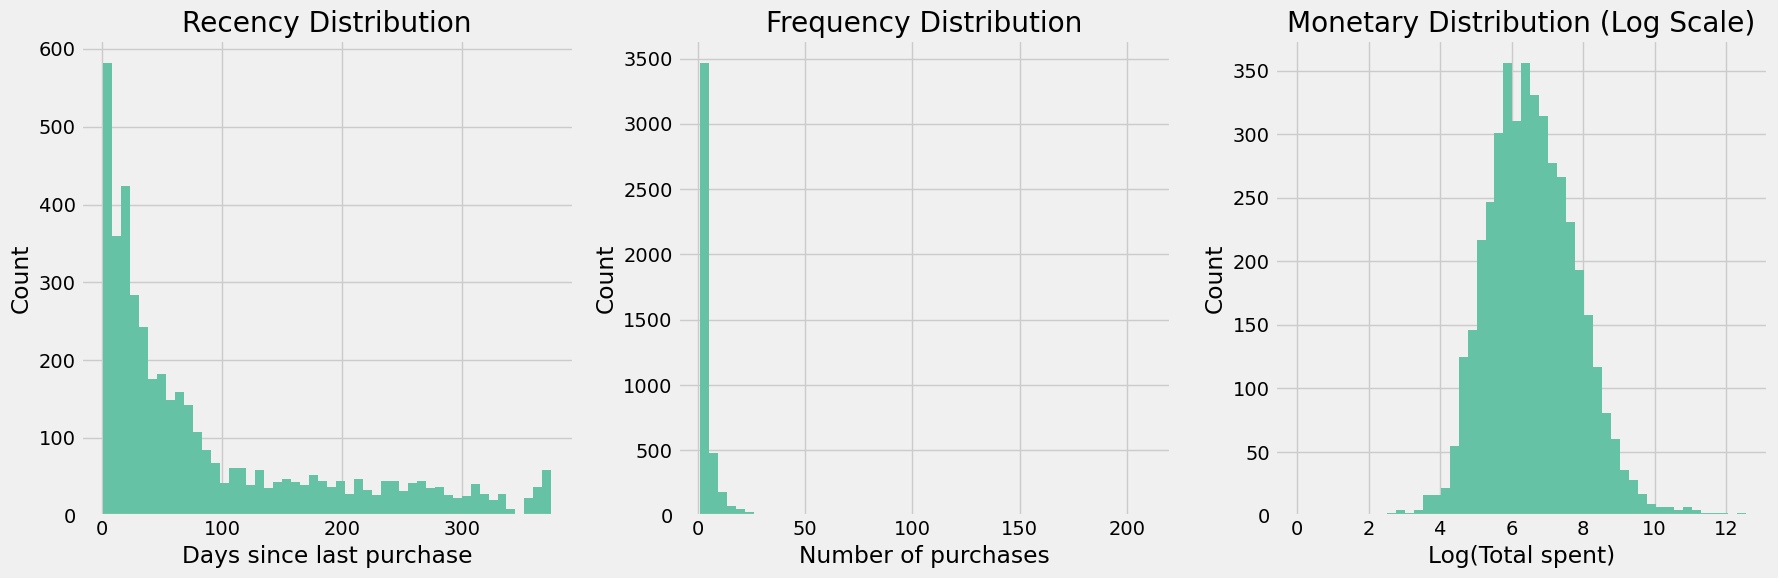

In [6]:
print("Performing RFM analysis...")

rfm = data.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'Amount': 'sum'
})

rfm.columns = ['Recency', 'Frequency', 'Monetary']

print("RFM DataFrame shape:", rfm.shape)
print("\nFirst few rows of RFM data:")
print(rfm.head())

print("\nRFM Statistics:")
print(rfm.describe())

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].hist(rfm['Recency'], bins=50)
axes[0].set_title('Recency Distribution')
axes[0].set_xlabel('Days since last purchase')
axes[0].set_ylabel('Count')

axes[1].hist(rfm['Frequency'], bins=50)
axes[1].set_title('Frequency Distribution')
axes[1].set_xlabel('Number of purchases')
axes[1].set_ylabel('Count')


axes[2].hist(np.log1p(rfm['Monetary']), bins=50)
axes[2].set_title('Monetary Distribution (Log Scale)')
axes[2].set_xlabel('Log(Total spent)')
axes[2].set_ylabel('Count')

plt.tight_layout()
plt.show()
